# Grindelwald Working Example
Set up the OGGM for the Upper Grindelwald Glacier, using all standard settings...

## Import

In [1]:
# import externals libs
import os
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

# import OGGM modules
import oggm
from oggm import cfg, graphics, utils
from oggm.utils import get_demo_file, get_rgi_glacier_entities
from oggm.tests.funcs import get_test_dir
from oggm.core import gis, climate, centerlines, massbalance, flowline, inversion

## Initialize

In [2]:
# load default parameter file
cfg.initialize()
# specify working directory
wdir = '/Users/oberrauch/work/grindelwald/working_directories/working_example/'
cfg.PATHS['working_dir'] = wdir

# using intersects
cfg.PARAMS['use_intersects'] = True

# define big border
cfg.PARAMS['border'] = 50

# set climate/massbalance hyper parameters for HistAlp dataset
cfg.PARAMS['baseline_climate'] = 'HISTALP'
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75

2019-04-16 14:19:36: oggm.cfg: Using configuration file: /Users/oberrauch/oggm-fork/oggm/params.cfg


## Preprocessing

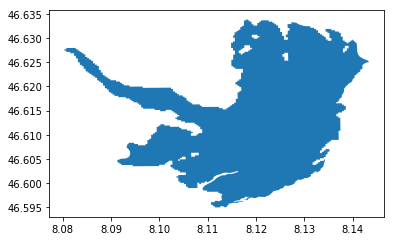

In [3]:
# get RGI entity
rgi_id = 'RGI60-11.01270'
rgi_df = get_rgi_glacier_entities([rgi_id], version='6')
rgi_entity = rgi_df.iloc[0]
rgi_df.plot()

In [4]:
# specify intersects
cfg.set_intersects_db(utils.get_rgi_intersects_region_file('11'))

In [5]:
# prepare glacier directory
gdir = oggm.GlacierDirectory(rgi_entity, reset=True)

### GIS

In [6]:
# GIS tasks
gis.define_glacier_region(gdir, entity=rgi_entity)
gis.glacier_masks(gdir)
gdir

2019-04-16 14:19:39: oggm.core.gis: (RGI60-11.01270) define_glacier_region
2019-04-16 14:19:39: oggm.core.gis: (RGI60-11.01270) glacier_masks


<oggm.GlacierDirectory>
  RGI id: RGI60-11.01270
  Region: 11: Central Europe
  Subregion: 11-01: Alps                            
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 9.023 km2
  Lon, Lat: (8.11933, 46.6143)
  Grid (nx, ny): (192, 183)
  Grid (dx, dy): (52.0, -52.0)

### Centerlines

In [7]:
# run center line preprocessing tasks
centerlines.compute_centerlines(gdir)
centerlines.initialize_flowlines(gdir)
centerlines.compute_downstream_line(gdir)
centerlines.compute_downstream_bedshape(gdir)
centerlines.catchment_area(gdir)
centerlines.catchment_intersections(gdir)
centerlines.catchment_width_geom(gdir)
centerlines.catchment_width_correction(gdir)

2019-04-16 14:19:39: oggm.core.centerlines: (RGI60-11.01270) compute_centerlines
2019-04-16 14:19:39: oggm.core.centerlines: (RGI60-11.01270) initialize_flowlines
2019-04-16 14:19:40: oggm.core.centerlines: (RGI60-11.01270) compute_downstream_line
2019-04-16 14:19:40: oggm.core.centerlines: (RGI60-11.01270) compute_downstream_bedshape
2019-04-16 14:19:40: oggm.core.centerlines: (RGI60-11.01270) catchment_area
2019-04-16 14:19:43: oggm.core.centerlines: (RGI60-11.01270) catchment_intersections
2019-04-16 14:19:43: oggm.core.centerlines: (RGI60-11.01270) catchment_width_geom
2019-04-16 14:19:44: oggm.core.centerlines: (RGI60-11.01270) catchment_width_correction


### Climate and mass balance parameters

In [8]:
# process the HistAlp climate file
climate.process_histalp_data(gdir)
climate.local_t_star(gdir)
climate.mu_star_calibration(gdir)

2019-04-16 14:19:47: oggm.core.climate: (RGI60-11.01270) process_histalp_data
2019-04-16 14:19:50: oggm.core.climate: (RGI60-11.01270) local_t_star
2019-04-16 14:19:50: oggm.core.climate: (RGI60-11.01270) local mu* computation for t*=1909
2019-04-16 14:19:50: oggm.core.climate: (RGI60-11.01270) mu_star_calibration


### Mass balance

In [9]:
# istance mass balance model using the historic climate file
mb_model = massbalance.PastMassBalance(gdir)

### Inversion

In [10]:
# run ice thicknes inversion
inversion.prepare_for_inversion(gdir)
factor = 1
inv_glen_a = cfg.PARAMS['inversion_glen_a'] * factor
inversion.mass_conservation_inversion(gdir, glen_a=inv_glen_a)
inversion.filter_inversion_output(gdir)

2019-04-16 14:19:50: oggm.core.inversion: (RGI60-11.01270) prepare_for_inversion
2019-04-16 14:19:50: oggm.core.inversion: (RGI60-11.01270) mass_conservation_inversion
2019-04-16 14:19:50: oggm.core.inversion: (RGI60-11.01270) filter_inversion_output


2019-04-16 14:19:52: oggm.core.inversion: (RGI60-11.01270) distribute_thickness_interp
2019-04-16 14:19:52: oggm.core.gis: (RGI60-11.01270) interpolation_masks


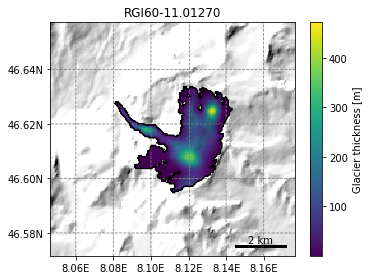

In [11]:
# visualize ice thickness
inversion.distribute_thickness_interp(gdir)
graphics.plot_distributed_thickness([gdir])

### Dynamic model

In [12]:
# finalize the preporcessing
flowline.init_present_time_glacier(gdir)

2019-04-16 14:19:54: oggm.core.flowline: (RGI60-11.01270) init_present_time_glacier


## Model

In [13]:
# read needed file
ci =  gdir.read_pickle('climate_info')
fls = gdir.read_pickle('model_flowlines')

In [14]:
# now we can use the flowline model
model = flowline.FluxBasedModel(fls, mb_model=mb_model, glen_a=cfg.PARAMS['glen_a']*factor,
                                y0=ci['baseline_hydro_yr_0'])

In [15]:
# run model over entire HistAlp period
_, ds_no_spinup = model.run_until_and_store(2014)

In [16]:
ds_no_spinup

<xarray.Dataset>
Dimensions:         (time: 213)
Coordinates:
  * time            (time) float64 1.802e+03 1.803e+03 1.804e+03 1.805e+03 ...
    hydro_year      (time) int64 1802 1803 1804 1805 1806 1807 1808 1809 ...
    hydro_month     (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    calendar_year   (time) int64 1801 1802 1803 1804 1805 1806 1807 1808 ...
    calendar_month  (time) int64 10 10 10 10 10 10 10 10 10 10 10 10 10 10 ...
Data variables:
    volume_m3       (time) float64 7.269e+08 7.096e+08 6.992e+08 6.894e+08 ...
    area_m2         (time) float64 9.033e+06 9.038e+06 9.038e+06 9.037e+06 ...
    length_m        (time) float64 6.136e+03 6.24e+03 6.24e+03 6.24e+03 ...
    ela_m           (time) float64 3.235e+03 3.092e+03 3.102e+03 2.896e+03 ...
Attributes:
    description:    OGGM model output
    oggm_version:   1.0.3+169.g7a98cea
    calendar:       365-day no leap
    creation_date:  2019-04-16 12:19:56

## Model with spinup

In [17]:
from oggm.tasks import run_constant_climate, run_from_climate_data

In [18]:
# let glacier spin up using the oldest possible constant climate
y0 = ci['baseline_hydro_yr_0'] + cfg.PARAMS['mu_star_halfperiod']
run_constant_climate(gdir, y0=y0, nyears=200, output_filesuffix='_spinup')

2019-04-16 14:20:19: oggm.core.flowline: (RGI60-11.01270) run_constant_climate_spinup
2019-04-16 14:20:19: oggm.core.flowline: (RGI60-11.01270) trying default time stepping scheme.
/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
2019-04-16 14:20:32: oggm.core.flowline: (RGI60-11.01270) default time stepping was successful!


In [19]:
# run model with over HistAlp climate period
run_from_climate_data(gdir, ys=ci['baseline_hydro_yr_0'], ye=2014,
                      init_model_filesuffix='_spinup',
                      output_filesuffix='_whit_spinup')

2019-04-16 14:20:32: oggm.core.flowline: (RGI60-11.01270) run_from_climate_data_whit_spinup
2019-04-16 14:20:33: oggm.core.flowline: (RGI60-11.01270) trying default time stepping scheme.
/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
2019-04-16 14:20:47: oggm.core.flowline: (RGI60-11.01270) default time stepping was successful!


In [20]:
utils.compile_glacier_statistics([gdir])
ds_spinup = utils.compile_run_output([gdir], filesuffix='_whit_spinup').squeeze('rgi_id')

2019-04-16 14:20:47: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers
2019-04-16 14:20:47: oggm.workflow: Multiprocessing: using all available processors (N=4)
2019-04-16 14:20:47: oggm.utils: (RGI60-11.01270) glacier_statistics
/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


## Results

In [21]:
# get length change measurements
from oggm.grindel.utils import get_leclercq_length
length_ref = get_leclercq_length('11.01270')

In [22]:
# get modeled length changes as DataFrame
length_no_spinup = ds_no_spinup.length_m.to_dataframe()[['hydro_year','length_m']]
length_no_spinup = length_no_spinup.reindex(index=length_no_spinup.hydro_year)
length_no_spinup.drop('hydro_year', axis=1, inplace=True)
length_no_spinup.columns = ['no_spinup']

In [23]:
# get modeled length changes as DataFrame
length_spinup = ds_spinup.length.to_dataframe()[['hydro_year','length']]
length_spinup = length_spinup.reindex(index=length_spinup.hydro_year)
length_spinup.drop('hydro_year', axis=1, inplace=True)
length_spinup.columns = ['spinup']

In [24]:
# combine both records
length_df = pd.concat([length_ref, length_no_spinup, length_spinup], axis=1)
# reference year for length change measurements
year_ref_zero = length_ref.abs().idxmin()
# get mean modeled length at reference year
length_offset = length_df.loc[year_ref_zero, ['no_spinup', 'spin_up']].mean(axis=1).iloc[0]
length_df.ref += length_offset

/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


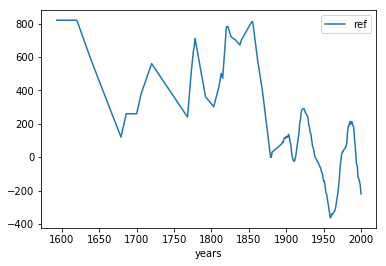

In [32]:
length_ref.plot()

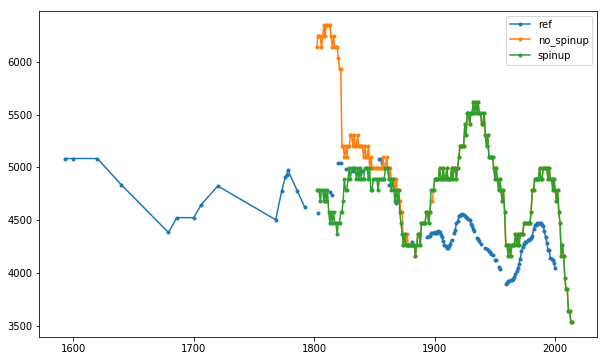

In [25]:
# plot lenght changes
length_df.plot(marker='.', figsize=[10,6])

The amplitude of the modeled length change is too large compared to the reference measurements. However, the temporal correlation seems quite good.

In [26]:
# compute correlation coefficient
length_df.corr()

,ref,no_spinup,spinup
ref,1.000000,0.595799,0.301221
no_spinup,0.595799,1.000000,0.589131
spinup,0.301221,0.589131,1.000000


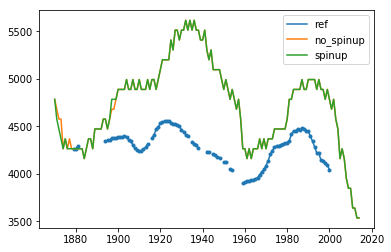

In [30]:
# select 'control' data period
start_year = 1870
control = length_df.loc[start_year:]
ax = control.plot()
ax.get_lines()[0].set_marker('.')